# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» планирует внедрение системы компьютерного зрения для анализа фотографий покупателей, сделанных в прикассовой зоне. Эта система позволит:

1. Анализировать покупки: По фотографии будет определяться возраст клиента, что позволит предлагать ему товары, которые могут быть интересны людям его возрастной группы. Это поможет повысить персонализацию предложений и, как следствие, увеличить продажи.
2. Контролировать продажу алкоголя: Система будет проверять, соблюдают ли кассиры требования закона при продаже алкоголя, что особенно важно при обслуживании клиентов, которые могут выглядеть младше своего возраста.
Задача проекта заключается в создании модели, которая по фотографии определяет приблизительный возраст человека. Для обучения и тестирования модели предоставлен набор данных, включающий фотографии людей с указанием их возраста.

## Описание данных
Данные для проекта взяты с сайта ChaLearn Looking at People. В вашем распоряжении следующие файлы:

* /final_files/: Папка, содержащая все изображения лиц людей, которые будут использоваться для обучения и тестирования модели.
* labels.csv: CSV-файл, содержащий два столбца:
    * file_name: Название файла изображения.
    * real_age: Реальный возраст человека, изображённого на фотографии.
    
Эти данные будут использованы для обучения нейронной сети, которая будет обучена предсказывать возраст на основе фотографии. Для предобработки изображений и подачи их в модель будет использован метод ImageDataGenerator из библиотеки Keras, который позволяет автоматически обрабатывать изображения и подавать их в модель в удобном формате.


## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
get_data_info(labels)

,file_name,real_age
5583,005583.jpg,55
2555,002555.jpg,25
3892,003892.jpg,22
853,000853.jpg,52
5714,005714.jpg,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,000718.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


In [5]:
labels.duplicated().sum()

0

In [6]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

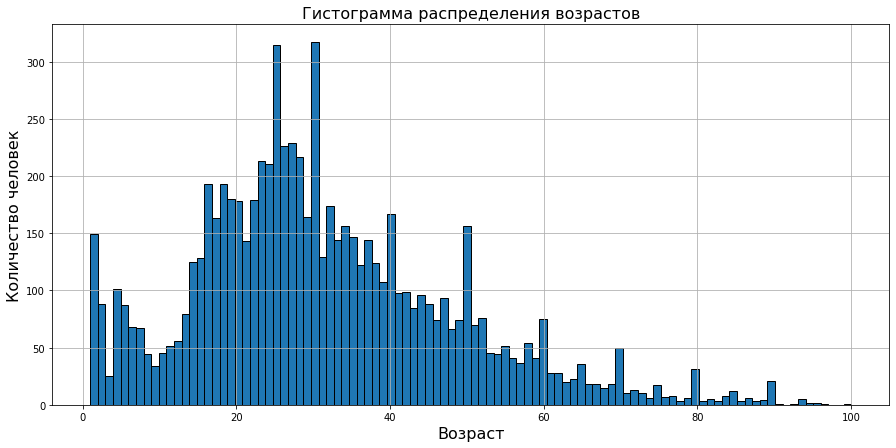

In [7]:
labels.hist(bins = 100, edgecolor = 'black', figsize = (15,7))
plt.title('Гистограмма распределения возрастов', fontsize=16)
plt.xlabel('Возраст', fontsize=16)
plt.ylabel('Количество человек', fontsize=16)
plt.show()

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


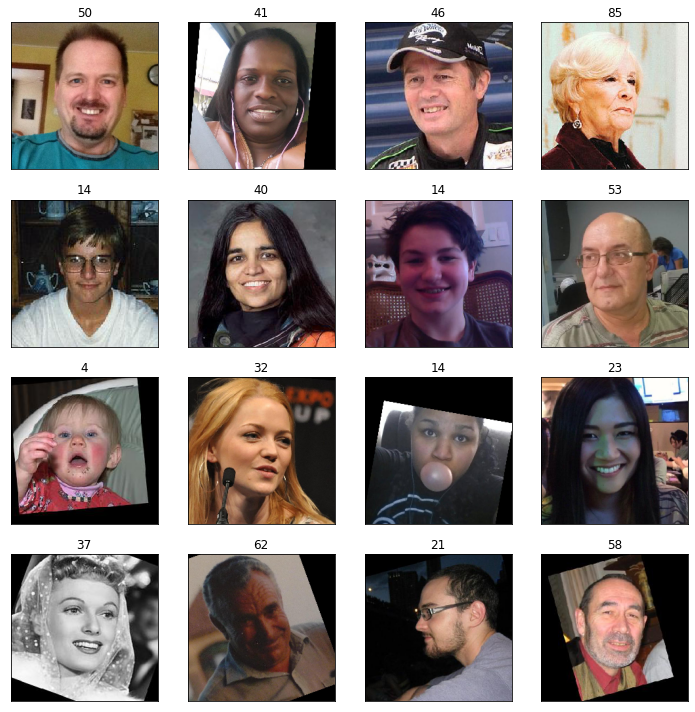

In [9]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))

num_images = len(features)
grid_size = 4  

for i in range(grid_size * grid_size):
    fig.add_subplot(grid_size, grid_size, i+1)
    
    if i < num_images:
        plt.imshow(features[i])
        plt.title(int(target[i]))
    else:
        plt.imshow(features[0])  
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

### Вывод исследовательского анализа:

Общая информация о данных:

Набор данных содержит 7591 изображение с указанием возраста людей.
В датасете отсутствуют пропущенные значения, и нет дублирующихся записей.

Распределение возраста:

Средний возраст в наборе данных составляет около 31 года, с минимальным значением в 1 год и максимальным — 100 лет.
Распределение возраста неравномерное, наблюдается пик в диапазоне 20-40 лет, что может свидетельствовать о преобладании изображений людей этого возраста.

Гистограмма распределения:

Гистограмма показывает неравномерное распределение возраста с преобладанием младших возрастных групп. Более старшие группы (50 лет и старше) представлены реже.
Видно, что на гистограмме есть несколько резких пиков и спадов, что может указывать на наличие неравномерно представленных возрастных групп.

Визуальный осмотр данных:

Проведенный визуальный осмотр случайных изображений показывает разнообразие представленных лиц, что подтверждает вариативность данных по возрасту.

## Обучение модели

```python

from tensorflow.keras.layers import Dense, AvgPool2D,Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/15
2024-08-25 04:04:05.407283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-08-25 04:04:06.616452: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 72s - loss: 214.5315 - mae: 10.5974 - val_loss: 509.4891 - val_mae: 17.4783
Epoch 2/15
356/356 - 44s - loss: 83.5726 - mae: 6.9203 - val_loss: 131.9487 - val_mae: 8.7857
Epoch 3/15
356/356 - 45s - loss: 56.2773 - mae: 5.7136 - val_loss: 176.4127 - val_mae: 10.7663
Epoch 4/15
356/356 - 45s - loss: 42.7965 - mae: 5.0080 - val_loss: 114.7517 - val_mae: 7.9712
Epoch 5/15
356/356 - 45s - loss: 32.9802 - mae: 4.4025 - val_loss: 69.3277 - val_mae: 6.2462
Epoch 6/15
356/356 - 45s - loss: 23.8846 - mae: 3.7500 - val_loss: 78.4257 - val_mae: 6.4666
Epoch 7/15
356/356 - 45s - loss: 20.6676 - mae: 3.4557 - val_loss: 70.3653 - val_mae: 6.3649
Epoch 8/15
356/356 - 45s - loss: 17.8192 - mae: 3.2043 - val_loss: 66.2091 - val_mae: 6.1264
Epoch 9/15
356/356 - 45s - loss: 14.9625 - mae: 2.9458 - val_loss: 69.3141 - val_mae: 6.2577
Epoch 10/15
356/356 - 44s - loss: 12.4460 - mae: 2.7067 - val_loss: 64.3077 - val_mae: 6.0140
Epoch 11/15
356/356 - 44s - loss: 12.5917 - mae: 2.6944 - val_loss: 69.1952 - val_mae: 6.1882
Epoch 12/15
356/356 - 44s - loss: 12.2358 - mae: 2.6735 - val_loss: 68.1271 - val_mae: 6.0036
Epoch 13/15
356/356 - 44s - loss: 12.1681 - mae: 2.6452 - val_loss: 62.1567 - val_mae: 5.9574
Epoch 14/15
356/356 - 44s - loss: 11.5688 - mae: 2.5816 - val_loss: 65.8371 - val_mae: 6.0965
Epoch 15/15
356/356 - 44s - loss: 9.7692 - mae: 2.3876 - val_loss: 63.0719 - val_mae: 5.9497
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 63.0719 - mae: 5.9497
Test MAE: 5.9497




```

## Анализ обученной модели

**Архитектура модели:**

* Модель построена на основе предварительно обученной сети ResNet50, использующей веса ImageNet.
* В качестве завершающего слоя используется глобальный слой усреднения (GlobalAveragePooling2D) и один полносвязный слой (Dense) с активацией ReLU для предсказания возраста.
* Модель оптимизировалась с использованием Adam optimizer с начальной скоростью обучения 0.0001.

**Результаты обучения:**

* Модель была обучена в течение 15 эпох.
* В начале обучения (Эпоха 1) значения потерь (loss) и средней абсолютной ошибки (MAE) на тренировочной выборке составляли 214.5315 и 10.5974 соответственно. На валидационной выборке эти значения были значительно выше: loss = 509.4891 и MAE = 17.4783.
* С каждой эпохой модель демонстрировала значительное улучшение, снижая ошибки как на тренировочных, так и на валидационных данных.
* В конце обучения (Эпоха 15) модель достигла loss = 9.7692 и MAE = 2.3876 на тренировочных данных и loss = 63.0719 и MAE = 5.9497 на валидационных данных.

**Оценка модели:**

* Значение MAE на тестовой выборке составляет 5.9497, что свидетельствует о том, что модель в среднем ошибается на 5-6 лет при предсказании возраста.
* Модель продемонстрировала хорошую способность к обучению, существенно снизив ошибку как на тренировочных, так и на валидационных данных. Это говорит о том, что модель способна хорошо обобщать информацию и, вероятно, не переобучена.

**Рекомендации:**

* Для дальнейшего улучшения точности модели можно провести дополнительную настройку гиперпараметров, такие как скорость обучения, или попробовать использовать дополнительные регуляризационные техники (например, Dropout).
* Также может быть полезным увеличение объема данных для обучения или применение более сложных техник аугментации изображений.
* Стоит обратить внимание на возможное наличие дисбаланса в данных, что может повлиять на точность предсказания для определенных возрастных групп. Использование методов, направленных на устранение этого дисбаланса, может дополнительно улучшить результаты модели.